# A crash course on adversarial attacks in machine learning

**Instructor:** Elvis Dohmatob, Phd. Senior researcher at Criteo AI Lab, Paris
 - Twitter: https://twitter.com/dohmatobelvis
 - Website: https://dohmatob.github.io/Research/

In this short course, you shall learn:

- The basic math behind these attacks
- Understand concentration of measure phenomenon / curse of dimensionality
- Play with basic attacks on scikit-learn logistic regression model
- Play with gradient-based attacks on convnet with CIFAR10 dataset


In [1]:
# install all major dependencies

!pip install numpy scipy
!pip install scikit-learn
!pip install torch torchvision

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## Relevant probability theory

It turns out the adversarial examples are a consequence of a geometric-probabilistic phenomenon known as *concentration of measure*. This can be seen as a quantitative version of the central limit theory, which holds for certain probability distributions (bounded, gaussian, sub-gaussian, log-concave, etc.).

We will do a quick review of the basic ideas.

### Concentration of measure

A symmetric random walk stays (very) close to zero!

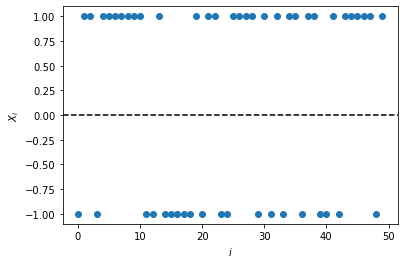

In [3]:
from sklearn.utils import check_random_state
rng = check_random_state(0)

n = 50
sample = rng.choice([-1, 1], size=n)

plt.scatter(range(n), sample);
plt.axhline(0, linestyle="--", c="k");
plt.ylabel("$X_i$");
plt.xlabel("$i$");

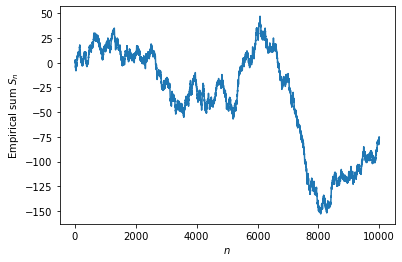

In [4]:
n_trials = 5000

stats = []
n = 10000
for _ in range(n_trials):
    sample = rng.choice([-1, 1], size=n)
    stats.append(sample.sum())
    
plt.plot(np.cumsum(sample));
plt.xlabel("$n$");
plt.ylabel("Empirical sum $S_n$");

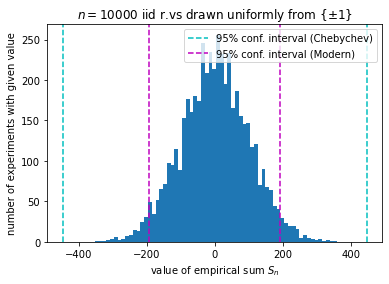

In [5]:
plt.hist(stats, bins=64);

delta = .05

for method, color in zip(["Chebychev", "Modern"], ["c", "m"]):
    if method == "Chebychev":
        bound = np.sqrt(n / delta)
    elif method == "Modern":
        bound = np.sqrt(n * np.log(2 / delta))
    else:
        raise NotImplementedError(method)

    plt.axvline(-bound, linestyle="--", c=color,
                label="%.0f%% conf. interval (%s)" % (100 * (1 - delta),
                                                  method));
    plt.axvline(bound, linestyle="--", c=color);

plt.xlabel("value of empirical sum $S_n$");
plt.ylabel("number of experiments with given value");
plt.title("$n=%d$ iid r.vs drawn uniformly from $\\{\\pm 1\\}$" % n);
plt.legend(loc="best");

# Concentration in higher dimensions (aka the curse of dimension!)

In high dimensions, the volume of a convex body is concencentrated close to the boundary. As we shall see (If we've not already in class), this serious implications for machine learning, vis-à-vis adversarial examples

- More details here http://proceedings.mlr.press/v97/dohmatob19a.html


In [26]:
from ipywidgets import interact, FloatSlider

def volume_of_shell(dim, epsilon=.01): 
    inner_width = 1 - 2 * epsilon
    assert inner_width >= 0
    return 1 - inner_width ** dim


@interact
def plot_volume_of_shell(epsilon=FloatSlider(value=.1, min=0, max=.5, step=.1)):
    dims = np.logspace(0, 3)
    plt.semilogx(dims, volume_of_shell(dims, epsilon=epsilon));
    # plt.ylim(0, 1.1);
    plt.xlabel("dimensionality $d$");
    plt.ylabel("volumne of shell of thickness $\\varepsilon = %.2f$" % epsilon);

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=0.5), Output()), _dom_classes=('widget…

# Basic adversarial attack on linear models

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
X = X[:, ::-1]
y = (iris.target != 0).astype("int")
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.3)

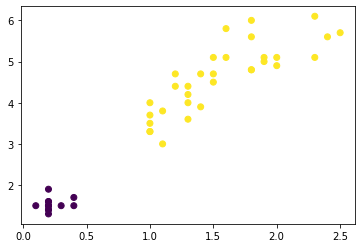

In [8]:
plt.scatter(*X_train.T[:2], c=y_train);

In [9]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

@interact
def plot_movement(epsilon=FloatSlider(value=0, min=0, max=1, step=.05)):
    # Plotting decision regions
    _, ax = plt.subplots(figsize=(8, 8));
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    count = len(xx.ravel())
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel(),
                             np.zeros(count), np.zeros(count)])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)

    pos_label = y_train[0]
    pos_mask = y_test == pos_label
    sign = 2 * pos_mask - 1
    perturbed = X_test - logreg.coef_ * epsilon * sign[:, None]
    y_pred = logreg.predict(perturbed)
    acc = np.mean(y_pred == y_test)
    ax.scatter(*perturbed.T[:2], c=y_pred, s=50, marker="o", edgecolor='k')
    plt.xlabel("$x_1$");
    plt.ylabel("$x_2$");
    plt.title("classification accuracy: %.2f%%" % (100 * acc))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, step=0.05), Output()), _dom_class…

# Adversarial attack on deep model

- Data loading, model spec, and training are courtesy official pytorch tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
batch_size = 200
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


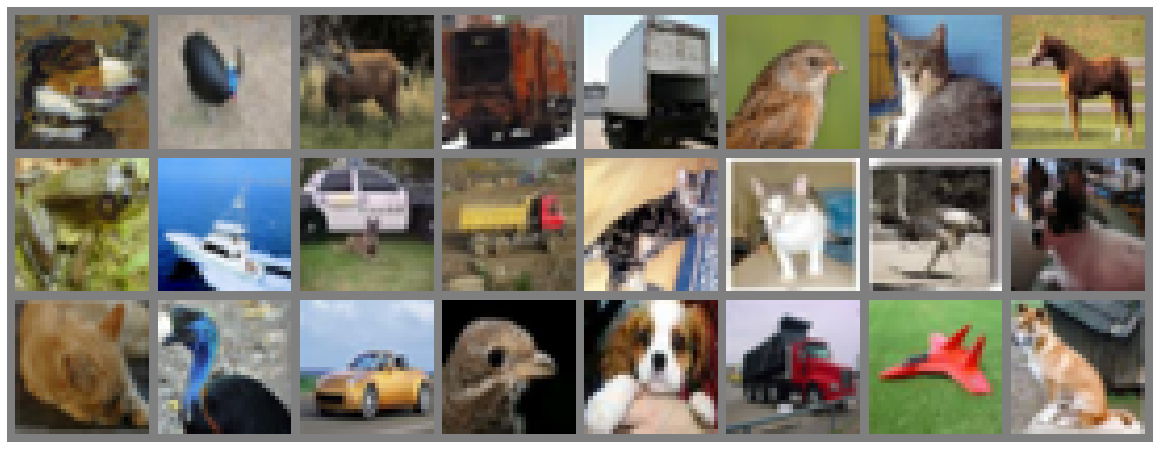

  dog  bird  deer truck truck  bird   cat horse  frog  ship   car truck   cat   cat  bird   dog   cat  bird   car  bird   dog truck plane   dog


In [12]:
# courtesy of https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(24, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:24]
labels = labels[:24]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

In [13]:
# model spec

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
# define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, # momentum=0.9
                       )

In [15]:
# train model

from tqdm.notebook import tqdm

n_epochs = 20
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/home/elvis/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[1,   200] loss: 0.182



[2,   200] loss: 0.149



[3,   200] loss: 0.139



[4,   200] loss: 0.131



[5,   200] loss: 0.124



[6,   200] loss: 0.119



[7,   200] loss: 0.114



[8,   200] loss: 0.110



[9,   200] loss: 0.106



[10,   200] loss: 0.103



[11,   200] loss: 0.100



[12,   200] loss: 0.097



[13,   200] loss: 0.095



[14,   200] loss: 0.092



[15,   200] loss: 0.090



[16,   200] loss: 0.088



[17,   200] loss: 0.087



[18,   200] loss: 0.084



[19,   200] loss: 0.082



[20,   200] loss: 0.081

Finished Training


In [16]:
# save model for later

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

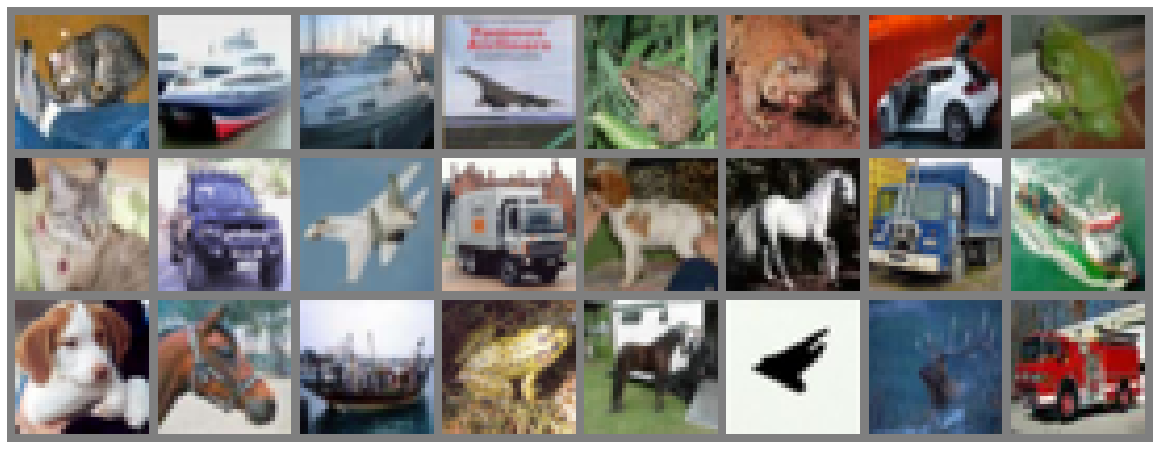

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck


In [17]:
# load some test data

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:24]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]]
                                for j in range(24)))

In [18]:
# load pretrained model

net = Net()
net.load_state_dict(torch.load(PATH));
print((net))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
# compute accuracy of model on test data

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [20]:
# compute class-specifica accuracy

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 88 %
Accuracy of  bird : 42 %
Accuracy of   cat : 52 %
Accuracy of  deer : 44 %
Accuracy of   dog : 40 %
Accuracy of  frog : 59 %
Accuracy of horse : 87 %
Accuracy of  ship : 68 %
Accuracy of truck : 78 %


In [21]:
# white-box gradient-based adversarial attack

import torch.autograd as autograd


class GradientSignAttack:
    def __init__(self, epsilon=.1):
        self.set_epsilon(epsilon)
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, model, images, labels, loss_func):
        images = autograd.Variable(images, requires_grad=True)
        pred_labels = model(images)
        loss = loss_func(pred_labels, labels)
        grad = autograd.grad(loss, images, retain_graph=True)[0]
        perturbed_images = images + epsilon * torch.sign(grad)
        return perturbed_images

0.00 ==> 0.62%
0.01 ==> 0.35%
0.02 ==> 0.20%
0.03 ==> 0.12%
0.04 ==> 0.06%
0.06 ==> 0.01%
0.07 ==> 0.01%
0.08 ==> 0.01%
0.09 ==> 0.01%
0.10 ==> 0.01%


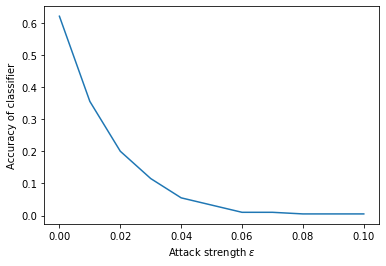

In [22]:
# run attack on test images and plot performance

attack = GradientSignAttack()
epsilons = np.linspace(0, .1, num=10)
epsilons = np.round(epsilons, 2)
screwed_images = {}
accs = []
for epsilon in epsilons:
    attack.set_epsilon(epsilon)
    screwed_images[epsilon] = {}
    modified = attack(model=net, images=images, labels=labels,
                      loss_func=criterion)
    probas_pred = F.softmax(net(modified), 1)
    labels_pred = probas_pred.argmax(1)
    acc = (labels_pred == labels).detach().numpy().mean()
    accs.append(acc)
    print("%.2f ==> %.2f%%" % (epsilon, acc))
    
    screwed_images[epsilon]["images"] = modified
    screwed_images[epsilon]["probas"] = probas_pred.max(1)[0]
    screwed_images[epsilon]["labels"] = labels_pred
    
plt.plot(epsilons, accs);
plt.xlabel("Attack strength $\\varepsilon$");
plt.ylabel("Accuracy of classifier");

In [23]:
!pip install opencv-python

In [24]:
# preplot for visualize the attack

from PIL import Image

import matplotlib.pyplot as plt
import cv2


def plot_image(image, probas=None, class_indices=None, ax=None,
               interpolation="bicubic", title=None):
    if ax is None:
      _, ax = plt.subplots(1, 1)
    if title is None and probas is not None:
        label, confidence = probas.argmax(), probas.max()
        label = class_indices[label]
        title = "%s (conf.: %d%%)" % (label, 100 * confidence)
    if hasattr(image, "numpy"):
        image = image.detach().cpu().numpy()
    if image.ndim == 3:
        image = image.transpose((1, 2, 0))
        image = cv2.normalize(image, None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_32F).astype("uint8")
    ax.imshow(image, interpolation=interpolation)
    ax.axis("off");
    if title:
        ax.set_title(title, fontsize=10);
        

def plot_grid(epsilon):
    n_cols = 8
    n_rows = 4
    n_plots = n_rows * n_cols
    s = 1.5
    images = screwed_images[epsilon]["images"][:n_plots]
    probas = screwed_images[epsilon]["probas"][:n_plots]
    labels = screwed_images[epsilon]["labels"][:n_plots]
    n_rows = max(1, int(np.ceil(len(images) // float(n_cols))))
    _, axes = plt.subplots(n_rows, n_cols, figsize=(s * n_cols, s * n_rows))

    for ax, adv, proba, label_pred in zip(axes.ravel(), images, probas, labels):
        label_pred = classes[label_pred.item()]
        tag = "%s (%.2f%%)" % (label_pred, 100 * proba)
        plot_image(adv, ax=ax, title=tag);
        ax.axis("off")

    plt.suptitle("$\\varepsilon = %.2f$" % epsilon, y=1.1);

    plt.subplots_adjust(wspace=0, hspace=0.15, left=0, right=1, bottom=0,
                        top=1);

    out_file = "./cifar10_epsilon=%0.3f.png" % (epsilon)
    plt.savefig(out_file, dpi=200, bbox_inches="tight");
    print("Saved %s" % out_file)
    plt.close("all")
    return out_file

cached_images = dict((epsilon, Image.open(plot_grid(epsilon)))
                      for epsilon in epsilons)

Saved ./cifar10_epsilon=0.000.png
Saved ./cifar10_epsilon=0.010.png
Saved ./cifar10_epsilon=0.020.png
Saved ./cifar10_epsilon=0.030.png
Saved ./cifar10_epsilon=0.040.png
Saved ./cifar10_epsilon=0.060.png
Saved ./cifar10_epsilon=0.070.png
Saved ./cifar10_epsilon=0.080.png
Saved ./cifar10_epsilon=0.090.png
Saved ./cifar10_epsilon=0.100.png


In [25]:
# visualize attack results

from ipywidgets import interact, SelectionSlider

@interact
def show_grid(eps=SelectionSlider(description='epsilon', 
                                  value=epsilons[len(epsilons) // 4],
                                  options=epsilons, continuous_update=False)):
    s = 2.2
    _, ax = plt.subplots(1, 1, figsize=(s * 8, s * 4))
    ax.imshow(cached_images[eps]);
    ax.set(frame_on=False);
    ax.axis("off");

interactive(children=(SelectionSlider(continuous_update=False, description='epsilon', index=2, options=(0.0, 0…

## Resources for self-study

- My ICML paper http://proceedings.mlr.press/v97/dohmatob19a.html
- Cleverhands adversarial attacks library https://github.com/cleverhans-lab/cleverhans
- IBM's adversarial attacks library https://github.com/Trusted-AI/adversarial-robustness-toolbox
- Madry's collection of tutorials on adversarial attacks https://gradientscience.org/